# Chemicals analysis

In [61]:
import os
import gc
import re
import requests
import time
import random

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from tqdm import tqdm
import pandas as pd
from concurrent.futures import ThreadPoolExecutor

import seaborn as sns
import networkx as nx
import statsmodels.api as sm
import statsmodels.formula.api as smf

from statsmodels.stats import diagnostic
from scipy import stats

from src.drugbank_XML_drugparser import DrugParser
from src.drugbank_bindingdb_merger import DrugBank_BindingDB_Merger
from src.preprocessing import Preprocessing, ColumnClean

from src.data_paths import *

%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## importing merged BDB and DB


In [62]:

merged_df = pd.read_pickle(MERGED)

In [63]:
merged_df.columns

Index(['ki', 'ph', 'temp', 'ic50', 'ec50', 'kd', 'kon', 'koff', 'doi',
       'target_name', 'pubchem_cid', 'chebi_id', 'chembl_id', 'drugbank_id',
       'kegg_id', 'zinc_id', 'smiles', 'inchi_key', 'bindingdb_id',
       'swissprot_target_chain_name', 'swissprot_target_chain_entry_name',
       'swissprot_protein_id', 'Unique_ID', 'drugbank_drug_name',
       'drugbank_drug_unii', 'drugbank_drug_toxicity',
       'drugbank_drug_class_kingdom', 'drugbank_drug_class_superclass',
       'drugbank_drug_synonyms', 'drugbank_drug_categories',
       'drugbank_drug_patent_approved', 'drugbank_drug_interaction',
       'Matched_On', 'drugbank_protein_name',
       'drugbank_protein_general_function',
       'drugbank_protein_specific_function', 'drugbank_protein_organism'],
      dtype='object')

In [64]:
merged_df["swissprot_target_chain_entry_name"].dropna().unique()

<StringArray>
[  'POL_HV1BR',   'POL_HV196', 'CP3A4_HUMAN', 'GALK1_HUMAN',   'POL_HV1N5',
 'CASP3_HUMAN', 'CASP1_HUMAN', 'CASP4_HUMAN', 'CASP7_HUMAN', 'CASP6_HUMAN',
 ...
 'CISY2_MYCTU',    'M2_I34A1',  'BMI1_HUMAN',  'CYSM_MYCTU', 'CYSK2_MYCTU',
  'TRYS_CRIFA',  'PDF2_ARATH',  'ANGT_HUMAN', 'TGFB2_HUMAN',  'LUXQ_VIBHA']
Length: 6533, dtype: string

In [65]:
merged_df["drugbank_protein_name"].dropna().unique()

array(['gag-pol', 'CCNA2', 'CCND1', 'CDK6', 'CDK5', '72', 'CDK7', 'CDK9',
       'CDK2', 'FNTB', 'PGGT1B', 'PIK3CA', 'ITGB1', 'ITGB7', 'ITGA5',
       'PIK3R2', 'PIK3CD', 'parE', 'gyrB', 'ureB', 'PIK3CB', 'GABRB3',
       'GABRA1', 'GABRA2', 'GABRA3', 'GABRA5', 'GABRA4', 'GABRA6',
       'GABRB2', 'APH1A', 'PRKAB1', 'PRKDC', 'MTOR', 'ABL1', 'HCK',
       'EGFR', 'EPHB4', 'PDGFRB', 'RARA', 'TGM2', 'JAK3', 'HTR1B',
       'MAPK9', 'INCENP', 'PDE3B', 'KDM1A', 'HSP90AA1', 'BTK', 'FYN',
       'LYN', 'MAPK1', 'HDAC8', 'PIK3R1', 'HTR2C', 'GHSR', 'PRKAG1',
       'PTGS2', 'GUCY1B1', 'GSTA1', 'TP53', 'ADRA2B', 'CHRNB2', 'MET',
       'ALK', 'RET', 'PPARG', 'GRM2', 'ITGB3', 'ATP1B1', 'HDAC2',
       'MAPKAPK2', 'MDM2', 'RXRA', 'MAPK3', 'MAP2K2', 'CACNB3', 'CFB',
       'TAS1R3', 'TAS1R2', 'GSTP1', 'TAB1', 'FGFR1', 'ROCK1', 'ROCK2',
       'ITGA4', 'CRBN', 'RAD51', 'SCN3A', 'CYP3A5', 'SERPINE1',
       'SERPINC1', 'ITGAV', 'ITGB6', 'RRM2', 'XIAP', 'CACNA2D1', 'P2RX2',
       'GRIN2B', 'KDR', 'GR

## Importing cancerous proteins dataframe and filtering merged_df

In [244]:
# loads cancerous protein dataframe
protein_classes = pd.read_csv("data/clean/protein_class_COSMIC.tsv", sep='\t')

for col in protein_classes.columns:
    print(col)
protein_classes

Gene
Gene synonym
Ensembl
Gene description
Uniprot
Chromosome
Position
Protein class
Biological process
Molecular function
Disease involvement
Evidence
HPA evidence
UniProt evidence
NeXtProt evidence
RNA tissue specificity
RNA tissue distribution
RNA tissue specificity score
RNA tissue specific nTPM
RNA single cell type specificity
RNA single cell type distribution
RNA single cell type specificity score
RNA single cell type specific nTPM
RNA single nuclei brain specificity
RNA single nuclei brain distribution
RNA single nuclei brain specificity score
RNA single nuclei brain specific nTPM
RNA cancer specificity
RNA cancer distribution
RNA cancer specificity score
RNA cancer specific FPKM
RNA brain regional specificity
RNA brain regional distribution
RNA brain regional specificity score
RNA brain regional specific nTPM
RNA blood cell specificity
RNA blood cell distribution
RNA blood cell specificity score
RNA blood cell specific nTPM
RNA blood lineage specificity
RNA blood lineage distri

,Gene,Gene synonym,Ensembl,Gene description,Uniprot,Chromosome,Position,Protein class,Biological process,Molecular function,...,Cancer prognostics - Pancreatic Adenocarcinoma (TCGA),Cancer prognostics - Pancreatic Adenocarcinoma (validation),Cancer prognostics - Prostate Adenocarcinoma (TCGA),Cancer prognostics - Rectum Adenocarcinoma (TCGA),Cancer prognostics - Rectum Adenocarcinoma (validation),Cancer prognostics - Skin Cuteneous Melanoma (TCGA),Cancer prognostics - Stomach Adenocarcinoma (TCGA),Cancer prognostics - Testicular Germ Cell Tumor (TCGA),Cancer prognostics - Thyroid Carcinoma (TCGA),Cancer prognostics - Uterine Corpus Endometrial Carcinoma (TCGA)
0,ABI1,"ABI-1, E3B1, SSH3BP1",ENSG00000136754,Abl interactor 1,Q8IZP0,10,26746593-26861087,"Cancer-related genes, Disease related genes, P...",Host-virus interaction,NaN,...,unprognostic (6.17e-3),unprognostic (9.66e-2),unprognostic (8.60e-2),unprognostic (1.16e-1),unprognostic (3.28e-2),unprognostic (1.01e-1),unprognostic (3.66e-1),unprognostic (1.72e-1),unprognostic (1.03e-1),unprognostic (1.72e-1)
1,ABL1,"ABL, c-ABL, JTK7, p150",ENSG00000097007,"ABL proto-oncogene 1, non-receptor tyrosine ki...",P00519,9,130713043-130887675,"Cancer-related genes, Disease related genes, E...","Apoptosis, Autophagy, Cell adhesion, DNA damag...","DNA-binding, Kinase, Transferase, Tyrosine-pro...",...,unprognostic (6.12e-2),unprognostic (3.31e-2),unprognostic (1.27e-1),unprognostic (2.01e-2),unprognostic (2.18e-1),unprognostic (2.61e-1),unprognostic (8.92e-2),unprognostic (3.15e-1),unprognostic (1.29e-1),unprognostic (1.96e-2)
2,ABL2,"ABLL, ARG",ENSG00000143322,"ABL proto-oncogene 2, non-receptor tyrosine ki...",P42684,1,179099330-179229684,"Cancer-related genes, Enzymes, Predicted intra...",Cell adhesion,"Kinase, Transferase, Tyrosine-protein kinase",...,unprognostic (2.27e-2),unprognostic (1.90e-3),unprognostic (1.86e-1),unprognostic (1.08e-1),unprognostic (7.21e-2),unprognostic (2.24e-1),unprognostic (9.34e-2),unprognostic (1.59e-1),unprognostic (2.71e-2),unprognostic (5.39e-2)
3,ACKR3,"CMKOR1, CXCR7, GPR159, RDC1",ENSG00000144476,Atypical chemokine receptor 3,P25106,2,236567787-236582354,"Cancer-related genes, Disease related genes, G...","Cell adhesion, Host-virus interaction","Developmental protein, G-protein coupled recep...",...,unprognostic (1.48e-3),unprognostic (8.51e-2),unprognostic (3.54e-2),unprognostic (1.21e-1),unprognostic (4.76e-3),unprognostic (1.29e-2),unprognostic (1.95e-4),unprognostic (1.41e-1),unprognostic (1.15e-3),unprognostic (4.99e-2)
4,ACSL3,"ACS3, FACL3, PRO2194",ENSG00000123983,Acyl-CoA synthetase long chain family member 3,O95573,2,222860942-222944639,"Cancer-related genes, Enzymes, Metabolic prote...","Fatty acid metabolism, Lipid metabolism",Ligase,...,unprognostic (7.65e-2),unprognostic (1.24e-1),unprognostic (2.88e-2),unprognostic (3.03e-1),unprognostic (2.64e-2),unprognostic (8.26e-2),unprognostic (9.29e-2),unprognostic (1.77e-1),unprognostic (1.08e-1),unprognostic (2.19e-1)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,ZMYM2,"FIM, MYM, RAMP, ZNF198",ENSG00000121741,Zinc finger MYM-type containing 2,Q9UBW7,13,19958677-20091829,"Cancer-related genes, Disease related genes, H...","Transcription, Transcription regulation",NaN,...,unprognostic (3.57e-2),unprognostic (4.85e-1),unprognostic (1.21e-1),unprognostic (4.77e-2),unprognostic (1.74e-1),unprognostic (7.15e-2),unprognostic (2.15e-1),unprognostic (1.08e-1),unprognostic (3.70e-3),unprognostic (1.30e-1)
568,ZNF331,"RITA, ZNF361, ZNF463",ENSG00000130844,Zinc finger protein 331,Q9NQX6,19,53519527-53580269,"Cancer-related genes, Predicted intracellular ...","Transcription, Transcription regulation",DNA-binding,...,unprognostic (1.35e-2),unprognostic (4.71e-2),unprognostic (4.12e-1),unprognostic (2.69e-1),unprognostic (5.47e-3),unprognostic (1.28e-2),unprognostic (1.03e-3),unprognostic (1.42e-1),unprognostic (2.32e-4),unprognostic (3.34e-2)
569,ZNF384,"CAGH1A, C

In [394]:
#Disease involvement, Biological process, Molecular function, RNA tissue distribution, RNA tissue specificity score,RNA cancer specificity score, RNA cancer distribution, Tissue expression cluster
protein_classes["Biological process"]

#RNA cancer specificity
#RNA cancer distribution
#RNA cancer specificity score
#RNA cancer specific FPKM


0                                 Host-virus interaction
1      Apoptosis, Autophagy, Cell adhesion, DNA damag...
2                                          Cell adhesion
3                  Cell adhesion, Host-virus interaction
4                Fatty acid metabolism, Lipid metabolism
                             ...                        
567              Transcription, Transcription regulation
568              Transcription, Transcription regulation
569              Transcription, Transcription regulation
570    Differentiation, Transcription, Transcription ...
571                       mRNA processing, mRNA splicing
Name: Biological process, Length: 572, dtype: object

In [251]:

# create lists of the relevant columns to identify cancerous proteins
cancer_proteins = list(protein_classes["Gene"].dropna().values)
genes_uniprot = list(protein_classes["Uniprot"].astype(str).dropna().values)

In [253]:
# joins all targeted proteins 
pattern_protein_names = '|'.join(rf"\b{re.escape(term)}\b" for term in cancer_proteins)
pattern_gene_names =  '|'.join(rf"\b{re.escape(term)}\b" for term in genes_uniprot)


#test
#pattern_protein_names

# extract rows based on the columns that contain cancer_keywords 
filtered_df = merged_df[
    #merged_df['drugbank_drug_unii'].str.contains(pattern_protein_names, case=False, na=False) |
    #merged_df['swissprot_target_chain_name'].str.contains(pattern_protein_names, case=False, na=False) |
    merged_df['swissprot_protein_id'].str.contains(pattern_gene_names, case=False, na=False) |
    merged_df['drugbank_protein_name'].str.contains(pattern_protein_names, case=False, na=False)
]
filtered_df.reset_index(inplace=True)


print(filtered_df.shape)
filtered_df.head()

(32324, 38)


,index,ki,ph,temp,ic50,ec50,kd,kon,koff,doi,...,drugbank_drug_class_superclass,drugbank_drug_synonyms,drugbank_drug_categories,drugbank_drug_patent_approved,drugbank_drug_interaction,Matched_On,drugbank_protein_name,drugbank_protein_general_function,drugbank_protein_specific_function,drugbank_protein_organism
0,8960,<NA>,7.6,22.0,840.0,<NA>,<NA>,<NA>,<NA>,10.1021/jm0201722,...,NaN,NaN,NaN,NaN,NaN,NaN,CCND1,Transcription factor binding,Regulatory component of the cyclin D1-CDK4 (DC...,Humans
1,8961,<NA>,7.6,22.0,490.0,<NA>,<NA>,<NA>,<NA>,10.1021/jm0201722,...,NaN,NaN,NaN,NaN,NaN,NaN,CCND1,Transcription factor binding,Regulatory component of the cyclin D1-CDK4 (DC...,Humans
2,8962,<NA>,7.6,22.0,640.0,<NA>,<NA>,<NA>,<NA>,10.1021/jm0201722,...,NaN,NaN,NaN,NaN,NaN,NaN,CCND1,Transcription factor binding,Regulatory component of the cyclin D1-CDK4 (DC...,Humans
3,8963,<NA>,7.6,22.0,1900.0,<NA>,<NA>,<NA>,<NA>,10.1021/jm0201722,...,NaN,NaN,NaN,NaN,NaN,NaN,CCND1,Transcription factor binding,Regulatory component of the cyclin D1-CDK4 (DC...,Humans
4,8964,<NA>,7.6,22.0,2800.0,<NA>,<NA>,<NA>,<NA>,10.1021/jm0201722,...,NaN,NaN,NaN,NaN,NaN,NaN,CCND1,Transcription factor binding,Regulatory component of the cyclin D1-CDK4 (DC...,Humans


In [254]:
filtered_df["target_name"].unique()

<StringArray>
[                                                                        'Cyclin-dependent kinase 4/G1/S-specific cyclin-D1',
                                                                         'Cyclin-dependent kinase 2/G1/S-specific cyclin-E1',
                                                                 'Cyclin-dependent kinase 4/G1/S-specific cyclin-D1 [L188C]',
                                                                 'Cyclin-dependent kinase 6/G1/S-specific cyclin-D1 [L188C]',
          'Phosphatidylinositol 3-kinase regulatory subunit alpha/4,5-bisphosphate 3-kinase catalytic subunit alpha isoform',
 'Phosphatidylinositol 3-kinase regulatory subunit alpha/4,5-bisphosphate 3-kinase catalytic subunit alpha isoform [H1047R]',
  'Phosphatidylinositol 3-kinase regulatory subunit alpha/4,5-bisphosphate 3-kinase catalytic subunit alpha isoform [E545K]',
           'Phosphatidylinositol 3-kinase regulatory subunit alpha/4,5-bisphosphate 3-kinase catalytic s

In [255]:
filtered_df["drugbank_protein_name"].dropna().unique()

array(['CCND1', 'CDK6', 'PIK3CA', 'PIK3CB', 'MTOR', 'ABL1', 'EGFR',
       'PDGFRB', 'RARA', 'JAK3', 'HSP90AA1', 'BTK', 'MAPK1', 'PIK3R1',
       'TP53', 'MET', 'ALK', 'RET', 'PPARG', 'MDM2', 'MAP2K2', 'FGFR1',
       'KDR', 'CD274', 'BCR', 'ATR', 'HSP90AB1', 'KRAS', 'IDH1', 'KCNJ5',
       'CTNNB1', 'MAP3K1', 'ABL2', 'AKT2', 'PDGFRA', 'JAK1', 'JAK2',
       'NPM1', 'FGFR2', 'EPAS1', 'RAF1', 'RAC1', 'ATIC', 'IDH2', 'ROS1'],
      dtype=object)

In [120]:
for i, col in enumerate(protein_classes.columns):
    for j, c in enumerate(filtered_df.columns):
        inter = set(protein_classes[col]).intersection(set(filtered_df[c]))
        if len(inter) >0:
            print(col, c)
            print(len(inter))
            print("*****************")

Gene drugbank_protein_name
45
*****************
Gene description target_name
1
*****************
Gene description swissprot_target_chain_name
3
*****************
Uniprot swissprot_protein_id
75
*****************
RNA tissue specificity score ki
22
*****************
RNA tissue specificity score ph
2
*****************
RNA tissue specificity score temp
3
*****************
RNA tissue specificity score ic50
23
*****************
RNA tissue specificity score ec50
21
*****************
RNA tissue specificity score kd
12
*****************
RNA single cell type specificity score ki
18
*****************
RNA single cell type specificity score ph
2
*****************
RNA single cell type specificity score temp
3
*****************
RNA single cell type specificity score ic50
18
*****************
RNA single cell type specificity score ec50
18
*****************
RNA single cell type specificity score kd
13
*****************
RNA single cell type specificity score bindingdb_id
2
*****************
RNA single n

In [133]:
merged_df[merged_df["drugbank_protein_name"].isin(protein_classes["Gene"])].shape

(20199, 37)

In [134]:
protein_classes[protein_classes["Gene"].isin(merged_df["drugbank_protein_name"])].shape

(45, 107)

In [72]:
# Find overlaps
overlap = set(protein_classes["Gene"]).intersection(set(merged_df["drugbank_protein_name"]))
print("Overlapping values:", overlap)
len(overlap)

Overlapping values: {'MAP3K1', 'PIK3CA', 'PDGFRA', 'EGFR', 'HSP90AB1', 'PPARG', 'IDH2', 'MET', 'ALK', 'EPAS1', 'TP53', 'BCR', 'CD274', 'PIK3CB', 'CDK6', 'ATR', 'RAF1', 'JAK3', 'AKT2', 'MAP2K2', 'RET', 'ABL1', 'PIK3R1', 'IDH1', 'KDR', 'JAK2', 'ATIC', 'ABL2', 'ROS1', 'KRAS', 'FGFR2', 'CCND1', 'CTNNB1', 'NPM1', 'KCNJ5', 'RAC1', 'MDM2', 'FGFR1', 'RARA', 'MTOR', 'BTK', 'MAPK1', 'HSP90AA1', 'JAK1', 'PDGFRB'}


45

In [73]:
overlap = set(merged_df["drugbank_protein_name"]).intersection(set(protein_classes["Gene"]))
print("Overlapping values:", overlap)
len(overlap)

Overlapping values: {'MAP3K1', 'PIK3CA', 'PDGFRA', 'EGFR', 'HSP90AB1', 'PPARG', 'IDH2', 'MET', 'ALK', 'EPAS1', 'TP53', 'BCR', 'CD274', 'PIK3CB', 'CDK6', 'ATR', 'RAF1', 'JAK3', 'AKT2', 'MAP2K2', 'RET', 'ABL1', 'PIK3R1', 'IDH1', 'KDR', 'JAK2', 'ATIC', 'ABL2', 'ROS1', 'KRAS', 'FGFR2', 'CCND1', 'CTNNB1', 'NPM1', 'KCNJ5', 'RAC1', 'MDM2', 'FGFR1', 'RARA', 'MTOR', 'BTK', 'MAPK1', 'HSP90AA1', 'JAK1', 'PDGFRB'}


45

## Cancer types

In [258]:
# loads cancerous protein dataframe
protein_classes = pd.read_csv("data/clean/protein_class_COSMIC.tsv", sep='\t')

for col in protein_classes.columns:
    print(col)

Gene
Gene synonym
Ensembl
Gene description
Uniprot
Chromosome
Position
Protein class
Biological process
Molecular function
Disease involvement
Evidence
HPA evidence
UniProt evidence
NeXtProt evidence
RNA tissue specificity
RNA tissue distribution
RNA tissue specificity score
RNA tissue specific nTPM
RNA single cell type specificity
RNA single cell type distribution
RNA single cell type specificity score
RNA single cell type specific nTPM
RNA single nuclei brain specificity
RNA single nuclei brain distribution
RNA single nuclei brain specificity score
RNA single nuclei brain specific nTPM
RNA cancer specificity
RNA cancer distribution
RNA cancer specificity score
RNA cancer specific FPKM
RNA brain regional specificity
RNA brain regional distribution
RNA brain regional specificity score
RNA brain regional specific nTPM
RNA blood cell specificity
RNA blood cell distribution
RNA blood cell specificity score
RNA blood cell specific nTPM
RNA blood lineage specificity
RNA blood lineage distri

In [ ]:
# Sample column (assuming 'protein_classes' DataFrame is already defined)
column = protein_classes["RNA cancer specific FPKM"]

# Create the dictionary
result_dict = []

for entry in column:
    cancer_dict = {}
    
    # Handle cases with missing values
    if pd.isna(entry):  # Use pd.isna to check for NaN
        cancer_dict = np.nan
    elif ';' in entry:  # Handle multiple cancer types separated by semicolons
        for pair in entry.split(';'):
            cancer_type, value = pair.split(':')
            cancer_dict[cancer_type.strip()] = float(value.strip())
    else:  # Handle case with only one cancer type-value pair
        cancer_type, value = entry.split(':')
        cancer_dict[cancer_type.strip()] = float(value.strip())
    
    result_dict.append(cancer_dict)

# The result_dict will now contain the processed cancer data
print(result_dict)

protein_classes["RNA cancer specific FPKM dict"] = result_dict
protein_classes["RNA cancer specific FPKM dict"].dropna()

[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, {'Breast Invasive Carcinoma (TCGA)': 24.4, 'Prostate Adenocarcinoma (TCGA)': 14.5}, nan, nan, nan, {'Glioblastoma Multiforme (TCGA)': 1.7, 'Ovary Serous Cystadenocarcinoma (TCGA)': 1.0, 'Skin Cuteneous Melanoma (TCGA)': 2.3, 'Thyroid Carcinoma (TCGA)': 1.5}, nan, nan, nan, {'Breast Invasive Carcinoma (TCGA)': 20.4, 'Prostate Adenocarcinoma (TCGA)': 18.0}, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, {'Colon Adenocarcinoma (TCGA)': 61.2, 'Rectum Adenocarcinoma (TCGA)': 64.2}, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, {'Testicular Germ Cell Tumor (TCGA)': 58.9}, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, {'Glioblastoma Multiforme (TCGA)': 809.4}, nan, nan, {'Cervical Squamous Cell Carcinoma and Endocervical Adenocarcinoma

10     {'Breast Invasive Carcinoma (TCGA)': 24.4, 'Pr...
14     {'Glioblastoma Multiforme (TCGA)': 1.7, 'Ovary...
18     {'Breast Invasive Carcinoma (TCGA)': 20.4, 'Pr...
36     {'Colon Adenocarcinoma (TCGA)': 61.2, 'Rectum ...
80           {'Testicular Germ Cell Tumor (TCGA)': 58.9}
                             ...                        
557    {'Lung Adenocarcinoma (TCGA)': 25.1, 'Uterine ...
559     {'Ovary Serous Cystadenocarcinoma (TCGA)': 79.6}
565             {'Prostate Adenocarcinoma (TCGA)': 21.4}
566     {'Ovary Serous Cystadenocarcinoma (TCGA)': 24.5}
570             {'Glioblastoma Multiforme (TCGA)': 19.6}
Name: RNA cancer specific FPKM dict, Length: 101, dtype: object

In [333]:
data = []  # List to store results

# Iterate through the rows of the DataFrame
for idx, row in protein_classes.iterrows():
    #print(row[0])  # Prints the first column in each row (0th index, adjust if needed)
    
    # Iterate through the dictionary in the column "RNA cancer specific FPKM dict"
    cancer_dict = row.get("RNA cancer specific FPKM dict")  # Get the dictionary (if present)
    
    # Check if the dictionary is not NaN
    if pd.notna(cancer_dict):
        # Loop through keys of the dictionary
        for key, fpkm in cancer_dict.items():
            # Assuming "Gene" is the column in the DataFrame, otherwise adjust the name
            gene_value = row["Gene"]  # Access Gene column value directly (adjust if needed)
            # Append data to the result list
            data.append([gene_value, key, fpkm])
    else:
        gene_value = row["Gene"]  # Access Gene column value directly (adjust if needed)
        data.append([gene_value, np.nan, np.nan])

# At the end, `data` will contain the result with Gene and associated dictionary keys

cancer_df = pd.DataFrame(data, columns=["Protein", "Cancer type", "FPKM"])
cancer_df


,Protein,Cancer type,FPKM
0,ABI1,NaN,NaN
1,ABL1,NaN,NaN
2,ABL2,NaN,NaN
3,ACKR3,NaN,NaN
4,ACSL3,NaN,NaN
...,...,...,...
606,ZMYM2,NaN,NaN
607,ZNF331,NaN,NaN
608,ZNF384,NaN,NaN
609,ZNF521,Glioblastoma Multiforme (TCGA),19.6


In [334]:
final_stats_df = pd.merge()

TypeError: merge() missing 2 required positional arguments: 'left' and 'right'

<Axes: xlabel='Protein'>

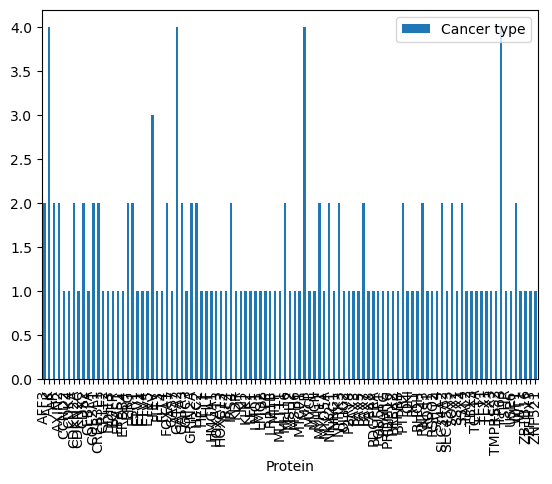

In [ ]:
# number of cancers where a given protein was found
cancer_types = cancer_df.groupby("Protein").count()
cancer_types.plot(kind="bar")

(array([-20.,   0.,  20.,  40.,  60.,  80., 100., 120.]),
 [Text(-20.0, 0, '−20'),
  Text(0.0, 0, '0'),
  Text(20.0, 0, '20'),
  Text(40.0, 0, '40'),
  Text(60.0, 0, '60'),
  Text(80.0, 0, '80'),
  Text(100.0, 0, '100'),
  Text(120.0, 0, '120')])

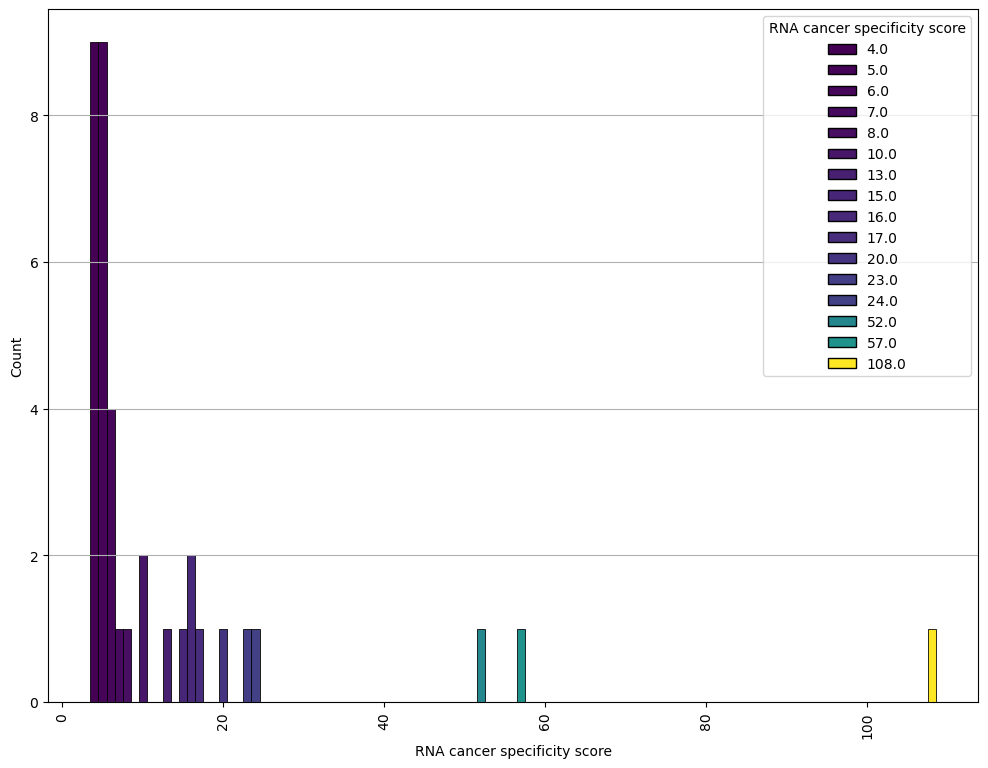

In [ ]:
droped_423 = protein_classes.drop(protein_classes[protein_classes["RNA cancer specificity score"]==423].index)
#droped_423["RNA cancer specificity score"]=droped_423["RNA cancer specificity score"].astype(str)
plt.figure(figsize=(12,9))
sns.histplot(x="RNA cancer specificity score", hue="RNA cancer specificity score",palette="viridis", binwidth=1, data=droped_423, alpha=1)
plt.grid(axis="y")
plt.xticks(rotation=90)

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74],
 [Text(0, 0, 'Cluster 77: Bone marrow - Cell proliferation'),
  Text(1, 0, 'Cluster 41: Smooth muscle tissue - ECM organization'),
  Text(2, 0, 'Cluster 34: Non-specific - Mixed function'),
  Text(3, 0, 'Cluster 7: Adipose tissue - Mixed function'),
  Text(4, 0, 'Cluster 24: Parathyroid gland - Vesicular transport'),
  Text(5, 0, 'Cluster 62: Connective tissue - ECM organization'),
  Text(6, 0, 'Cluster 21: Testis - Unknown function'),
  Text(7, 0, 'Cluster 27: Squamous epithelium - Keratinization'),
  Text(8, 0, 'Cluster 19: Non-specific - Basic cellul

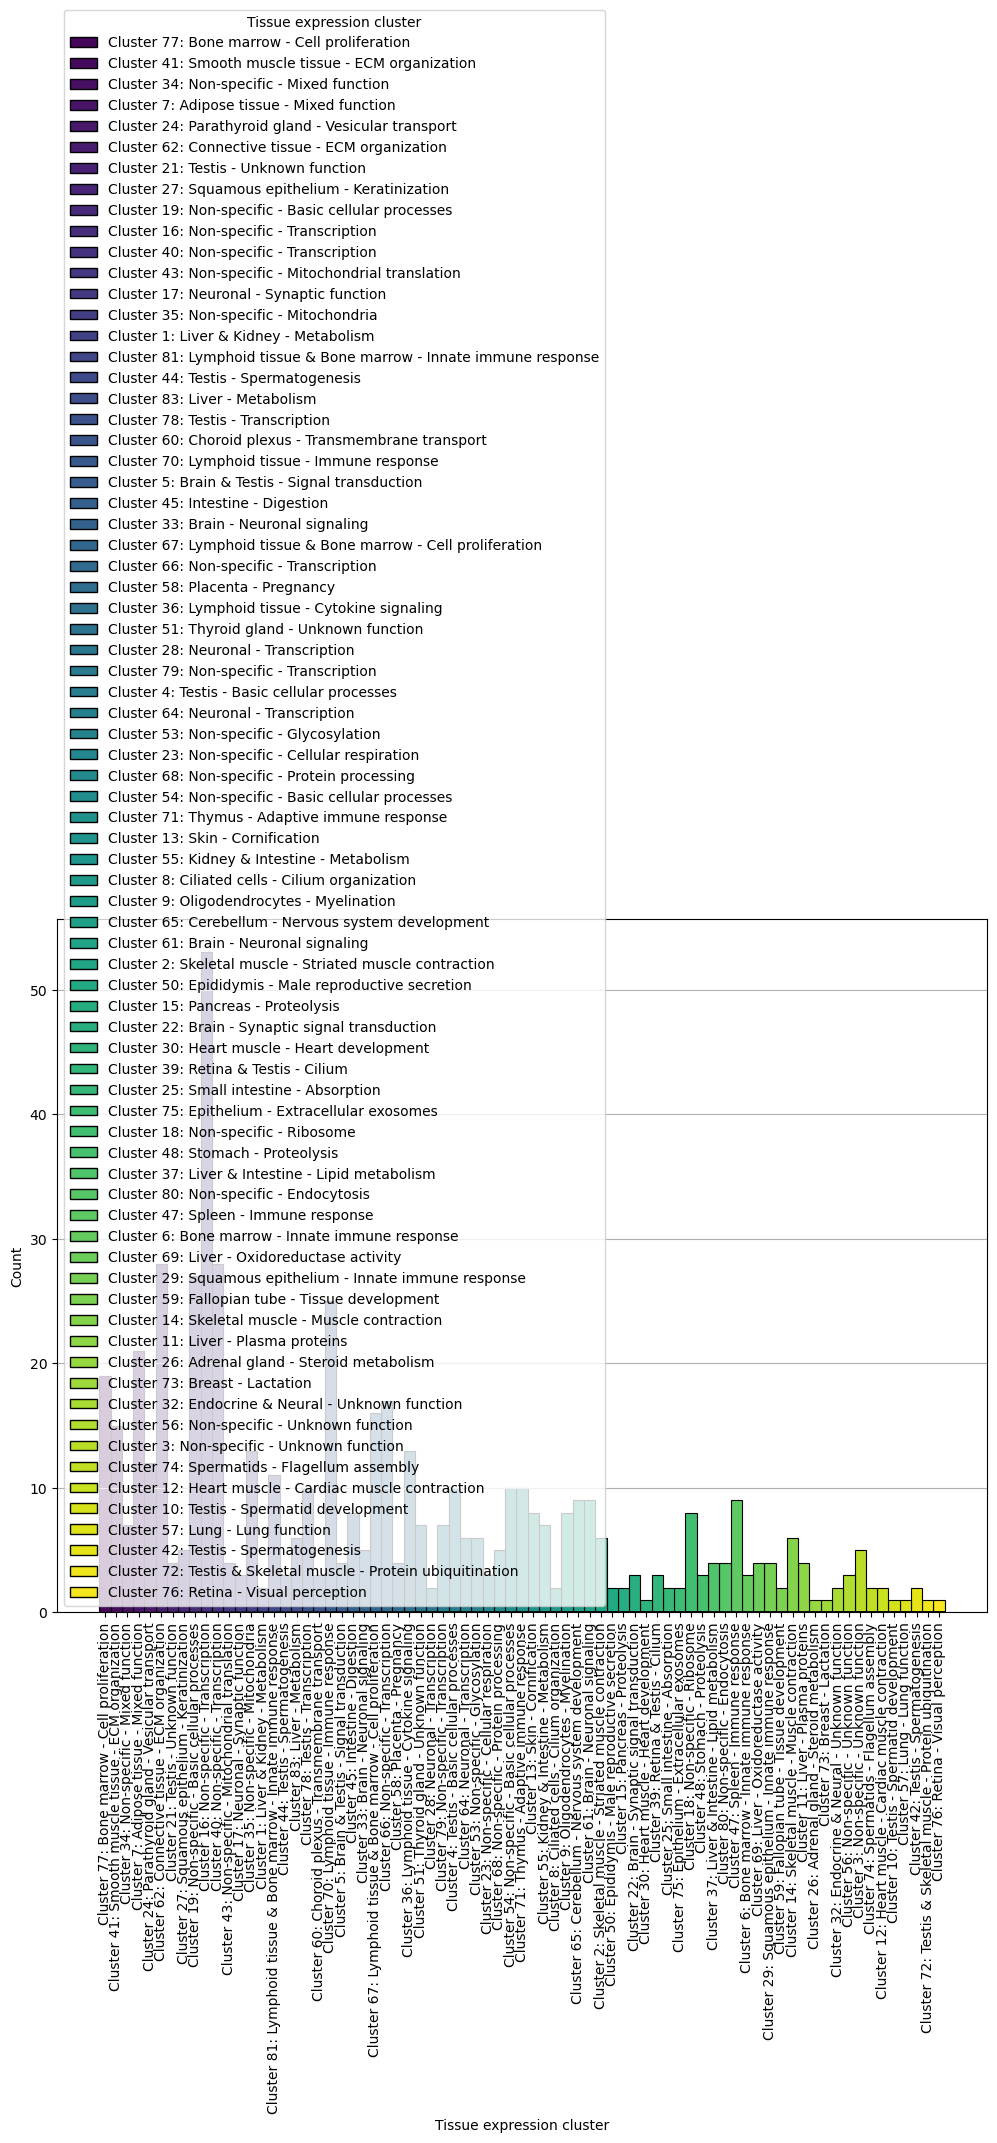

In [ ]:
plt.figure(figsize=(12,9))
sns.histplot(x="Tissue expression cluster", hue="Tissue expression cluster",palette="viridis", binwidth=1, data=protein_classes, alpha=1)
plt.grid(axis="y")
plt.xticks(rotation=90)

## getting p-values for cancer prognosis

In [ ]:


# Extract column names that start with "Cancer"
cancer_columns = [col for col in protein_classes.columns if col.startswith("Cancer")]

# Print the extracted column names
print(cancer_columns)

# Use regex to extract the numbers inside brackets
for col in cancer_columns:
    protein_classes[col] = protein_classes[col].str.extract(r'\((.*?)\)')
    protein_classes[col]=protein_classes[col].astype(float)
    
# Display the updated DataFrame with the cleaned column
print(protein_classes[cancer_columns])

Gene
Gene synonym
Ensembl
Gene description
Uniprot
Chromosome
Position
Protein class
Biological process
Molecular function
Disease involvement
Evidence
HPA evidence
UniProt evidence
NeXtProt evidence
RNA tissue specificity
RNA tissue distribution
RNA tissue specificity score
RNA tissue specific nTPM
RNA single cell type specificity
RNA single cell type distribution
RNA single cell type specificity score
RNA single cell type specific nTPM
RNA single nuclei brain specificity
RNA single nuclei brain distribution
RNA single nuclei brain specificity score
RNA single nuclei brain specific nTPM
RNA cancer specificity
RNA cancer distribution
RNA cancer specificity score
RNA cancer specific FPKM
RNA brain regional specificity
RNA brain regional distribution
RNA brain regional specificity score
RNA brain regional specific nTPM
RNA blood cell specificity
RNA blood cell distribution
RNA blood cell specificity score
RNA blood cell specific nTPM
RNA blood lineage specificity
RNA blood lineage distri

## merging dataframes to see what proportion of drugs are present in BindingDB

In [368]:
df = pd.merge(filtered_df, protein_classes, left_on ="drugbank_protein_name", right_on="Gene", how="left")
for col in df.columns:
    print(col)


index
ki
ph
temp
ic50
ec50
kd
kon
koff
doi
target_name
pubchem_cid
chebi_id
chembl_id
drugbank_id
kegg_id
zinc_id
smiles
inchi_key
bindingdb_id
swissprot_target_chain_name
swissprot_target_chain_entry_name
swissprot_protein_id
Unique_ID
drugbank_drug_name
drugbank_drug_unii
drugbank_drug_toxicity
drugbank_drug_class_kingdom
drugbank_drug_class_superclass
drugbank_drug_synonyms
drugbank_drug_categories
drugbank_drug_patent_approved
drugbank_drug_interaction
Matched_On
drugbank_protein_name
drugbank_protein_general_function
drugbank_protein_specific_function
drugbank_protein_organism
Gene
Gene synonym
Ensembl
Gene description
Uniprot
Chromosome
Position
Protein class
Biological process
Molecular function
Disease involvement
Evidence
HPA evidence
UniProt evidence
NeXtProt evidence
RNA tissue specificity
RNA tissue distribution
RNA tissue specificity score
RNA tissue specific nTPM
RNA single cell type specificity
RNA single cell type distribution
RNA single cell type specificity score
RNA 

In [391]:
filtered_cancers = protein_classes[
    protein_classes["Gene"].isin(filtered_df["drugbank_protein_name"]) | 
    protein_classes["Uniprot"].isin(filtered_df["swissprot_protein_id"])
    ]

filtered_cancers.columns

Index(['Gene', 'Gene synonym', 'Ensembl', 'Gene description', 'Uniprot',
       'Chromosome', 'Position', 'Protein class', 'Biological process',
       'Molecular function',
       ...
       'Cancer prognostics - Pancreatic Adenocarcinoma (validation)',
       'Cancer prognostics - Prostate Adenocarcinoma (TCGA)',
       'Cancer prognostics - Rectum Adenocarcinoma (TCGA)',
       'Cancer prognostics - Rectum Adenocarcinoma (validation)',
       'Cancer prognostics - Skin Cuteneous Melanoma (TCGA)',
       'Cancer prognostics - Stomach Adenocarcinoma (TCGA)',
       'Cancer prognostics - Testicular Germ Cell Tumor (TCGA)',
       'Cancer prognostics - Thyroid Carcinoma (TCGA)',
       'Cancer prognostics - Uterine Corpus Endometrial Carcinoma (TCGA)',
       'RNA cancer specific FPKM dict'],
      dtype='object', length=108)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35],
 [Text(0, 0, 'Cluster 41: Smooth muscle tissue - ECM organization'),
  Text(1, 0, 'Cluster 34: Non-specific - Mixed function'),
  Text(2, 0, 'Cluster 19: Non-specific - Basic cellular processes'),
  Text(3, 0, 'Cluster 17: Neuronal - Synaptic function'),
  Text(4, 0, 'Cluster 35: Non-specific - Mitochondria'),
  Text(5, 0, 'Cluster 16: Non-specific - Transcription'),
  Text(6, 0, 'Cluster 33: Brain - Neuronal signaling'),
  Text(7, 0, 'Cluster 70: Lymphoid tissue - Immune response'),
  Text(8, 0, 'Cluster 27: Squamous epithelium - Keratinization'),
  Text(9, 0, 'Cluster 13: Skin - Cornification'),
  Text(10, 0, 'Cluster 7: Adipose tissue - Mixed function'),
  Text(11, 0, 'Cluster 77: Bone marrow - Cell proliferation'),
  Text(12, 0, 'Cluster 55: Kidney & Intestine - Metabolism'),
  

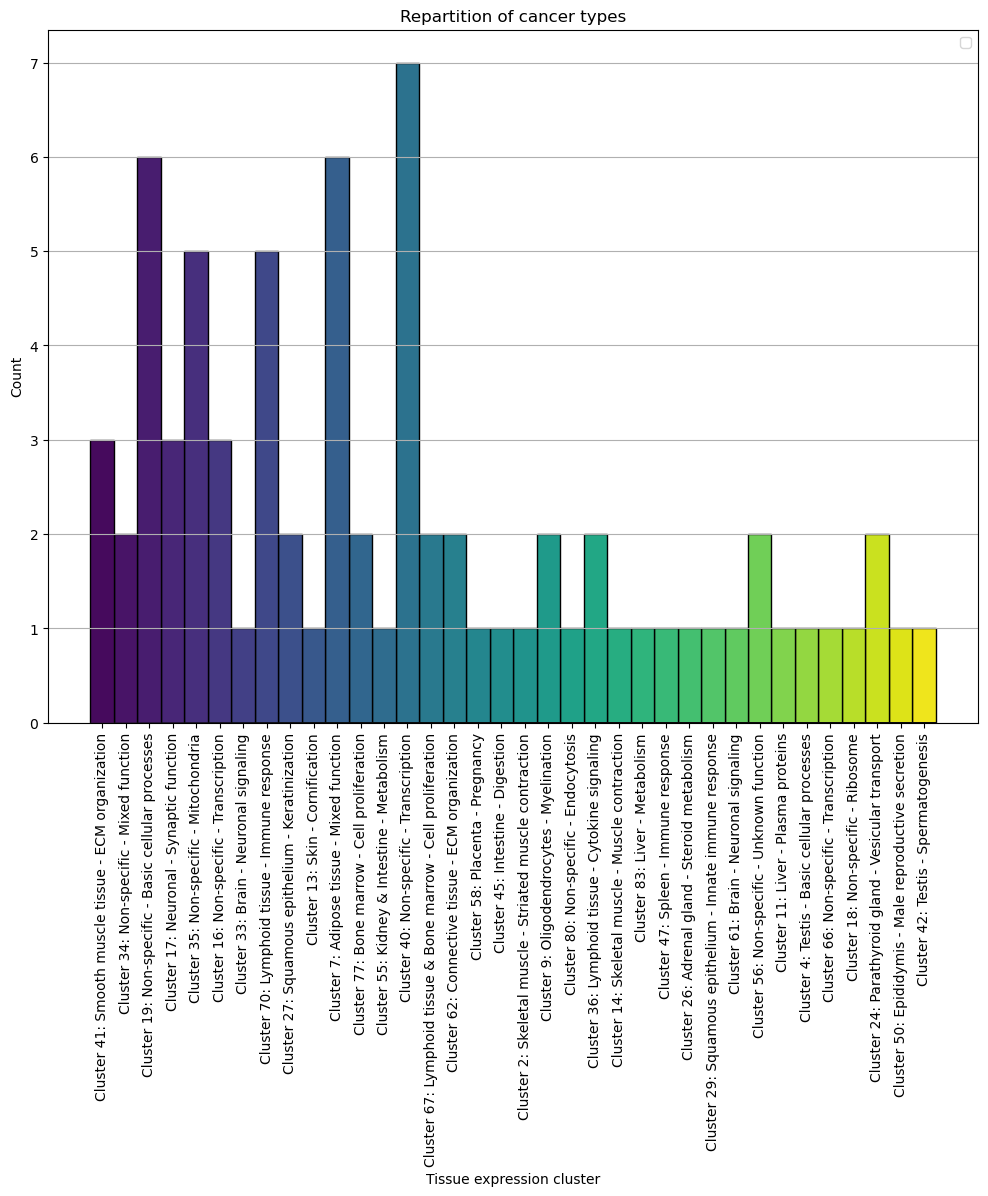

In [364]:
plt.figure(figsize=(12,9))
sns.histplot(x="Tissue expression cluster", hue="Tissue expression cluster",palette="viridis", binwidth=1, data=filtered_cancers, alpha=1)
plt.legend()
plt.grid(axis="y")
plt.title("Repartition of cancer types")
plt.xticks(rotation=90)

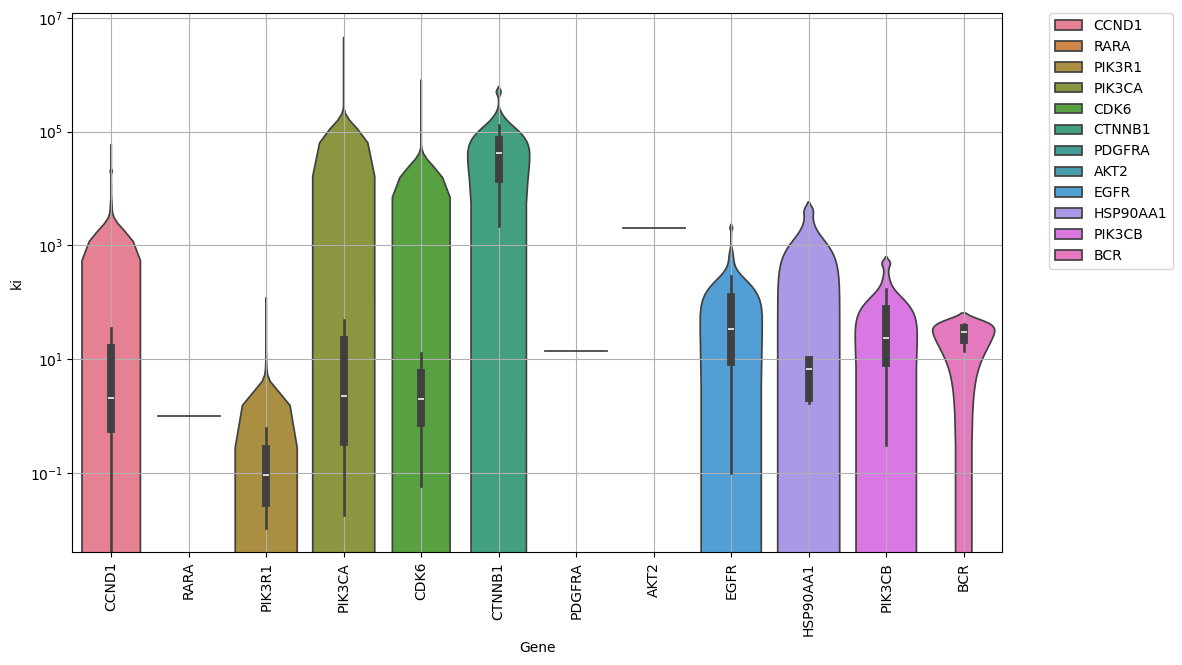

In [389]:
df_ki= df[df.ki.notna()]

plt.figure(figsize=(12,7))
sns.violinplot(x="Gene", y="ki", hue="Gene", data=df_ki)
plt.xticks(rotation=90)
plt.yscale("log")
plt.grid()
# Adjust legend position (outside the plot)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)


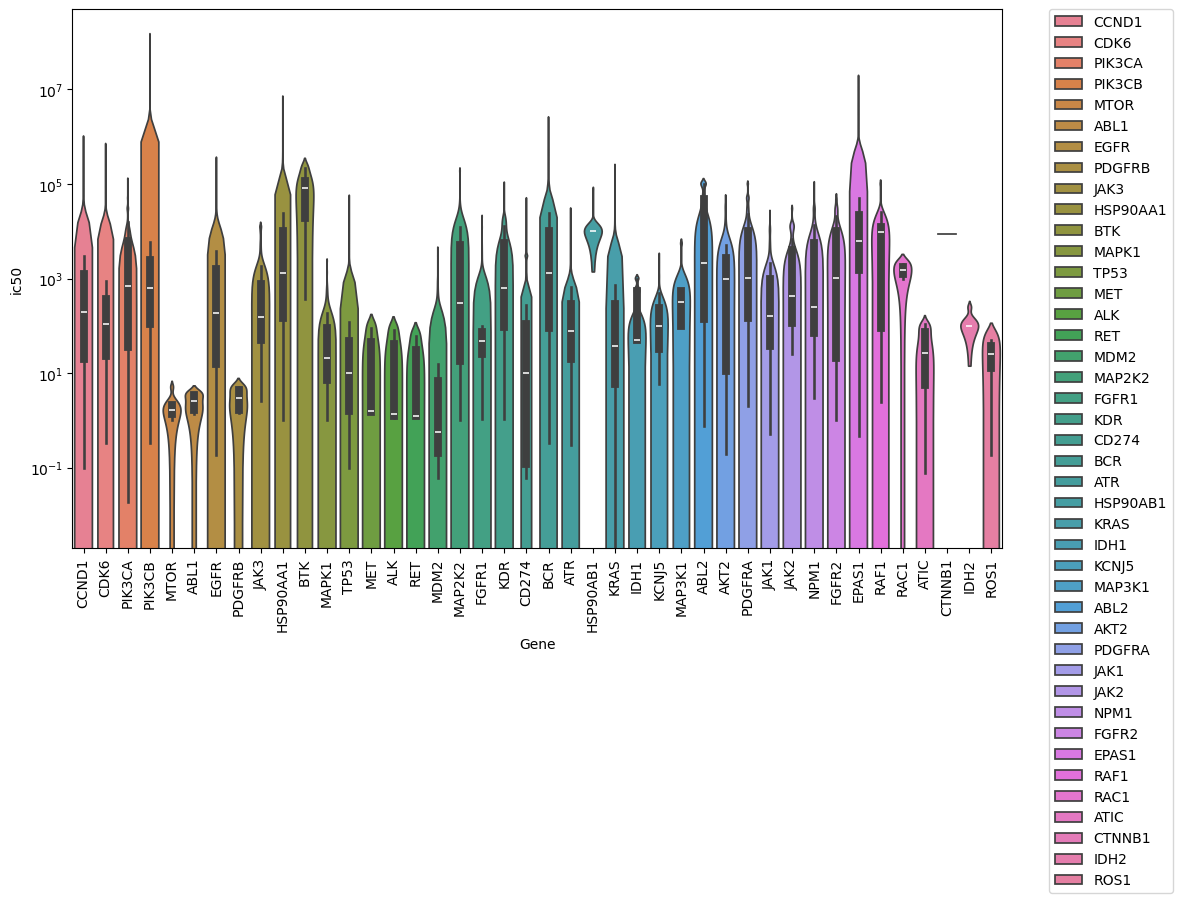

In [ ]:
df_ic50= df[df.ic50.notna()]

plt.figure(figsize=(12,7))
sns.violinplot(x="Gene", y="ic50", hue="Gene", data=df_ic50)
plt.xticks(rotation=90)
plt.yscale("log")
# Adjust legend position (outside the plot)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)


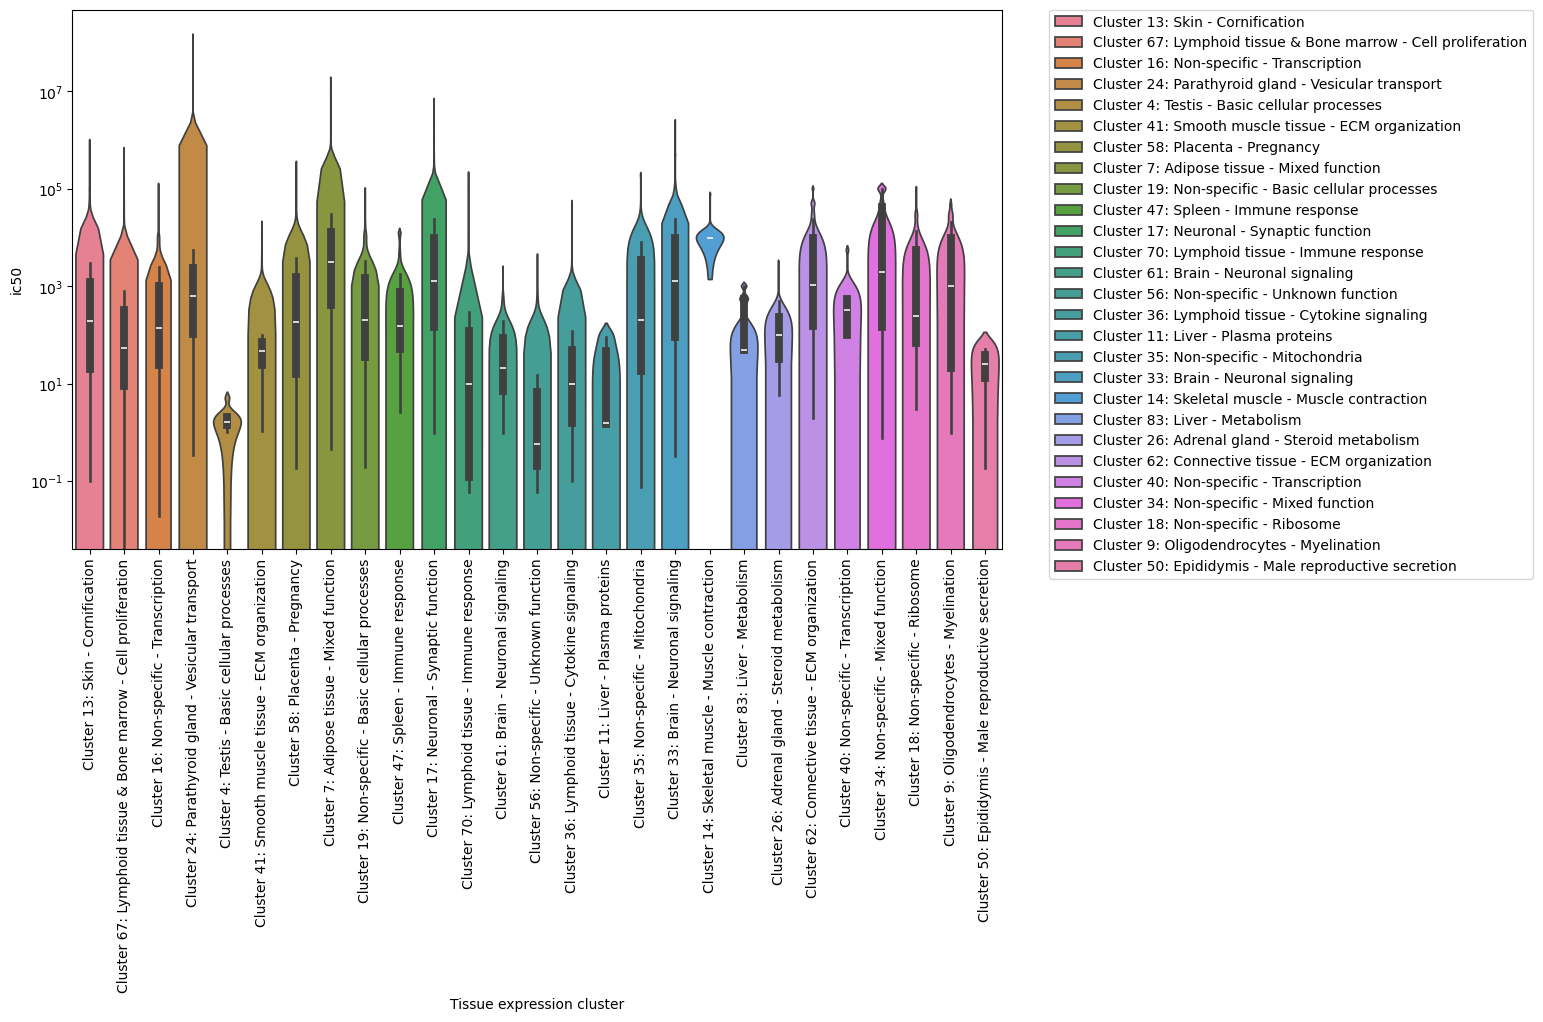

In [393]:
plt.figure(figsize=(12,7))
sns.violinplot(x="Tissue expression cluster", y="ic50", hue="Tissue expression cluster", data=df)
plt.xticks(rotation=90)
plt.yscale("log")
# Adjust legend position (outside the plot)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

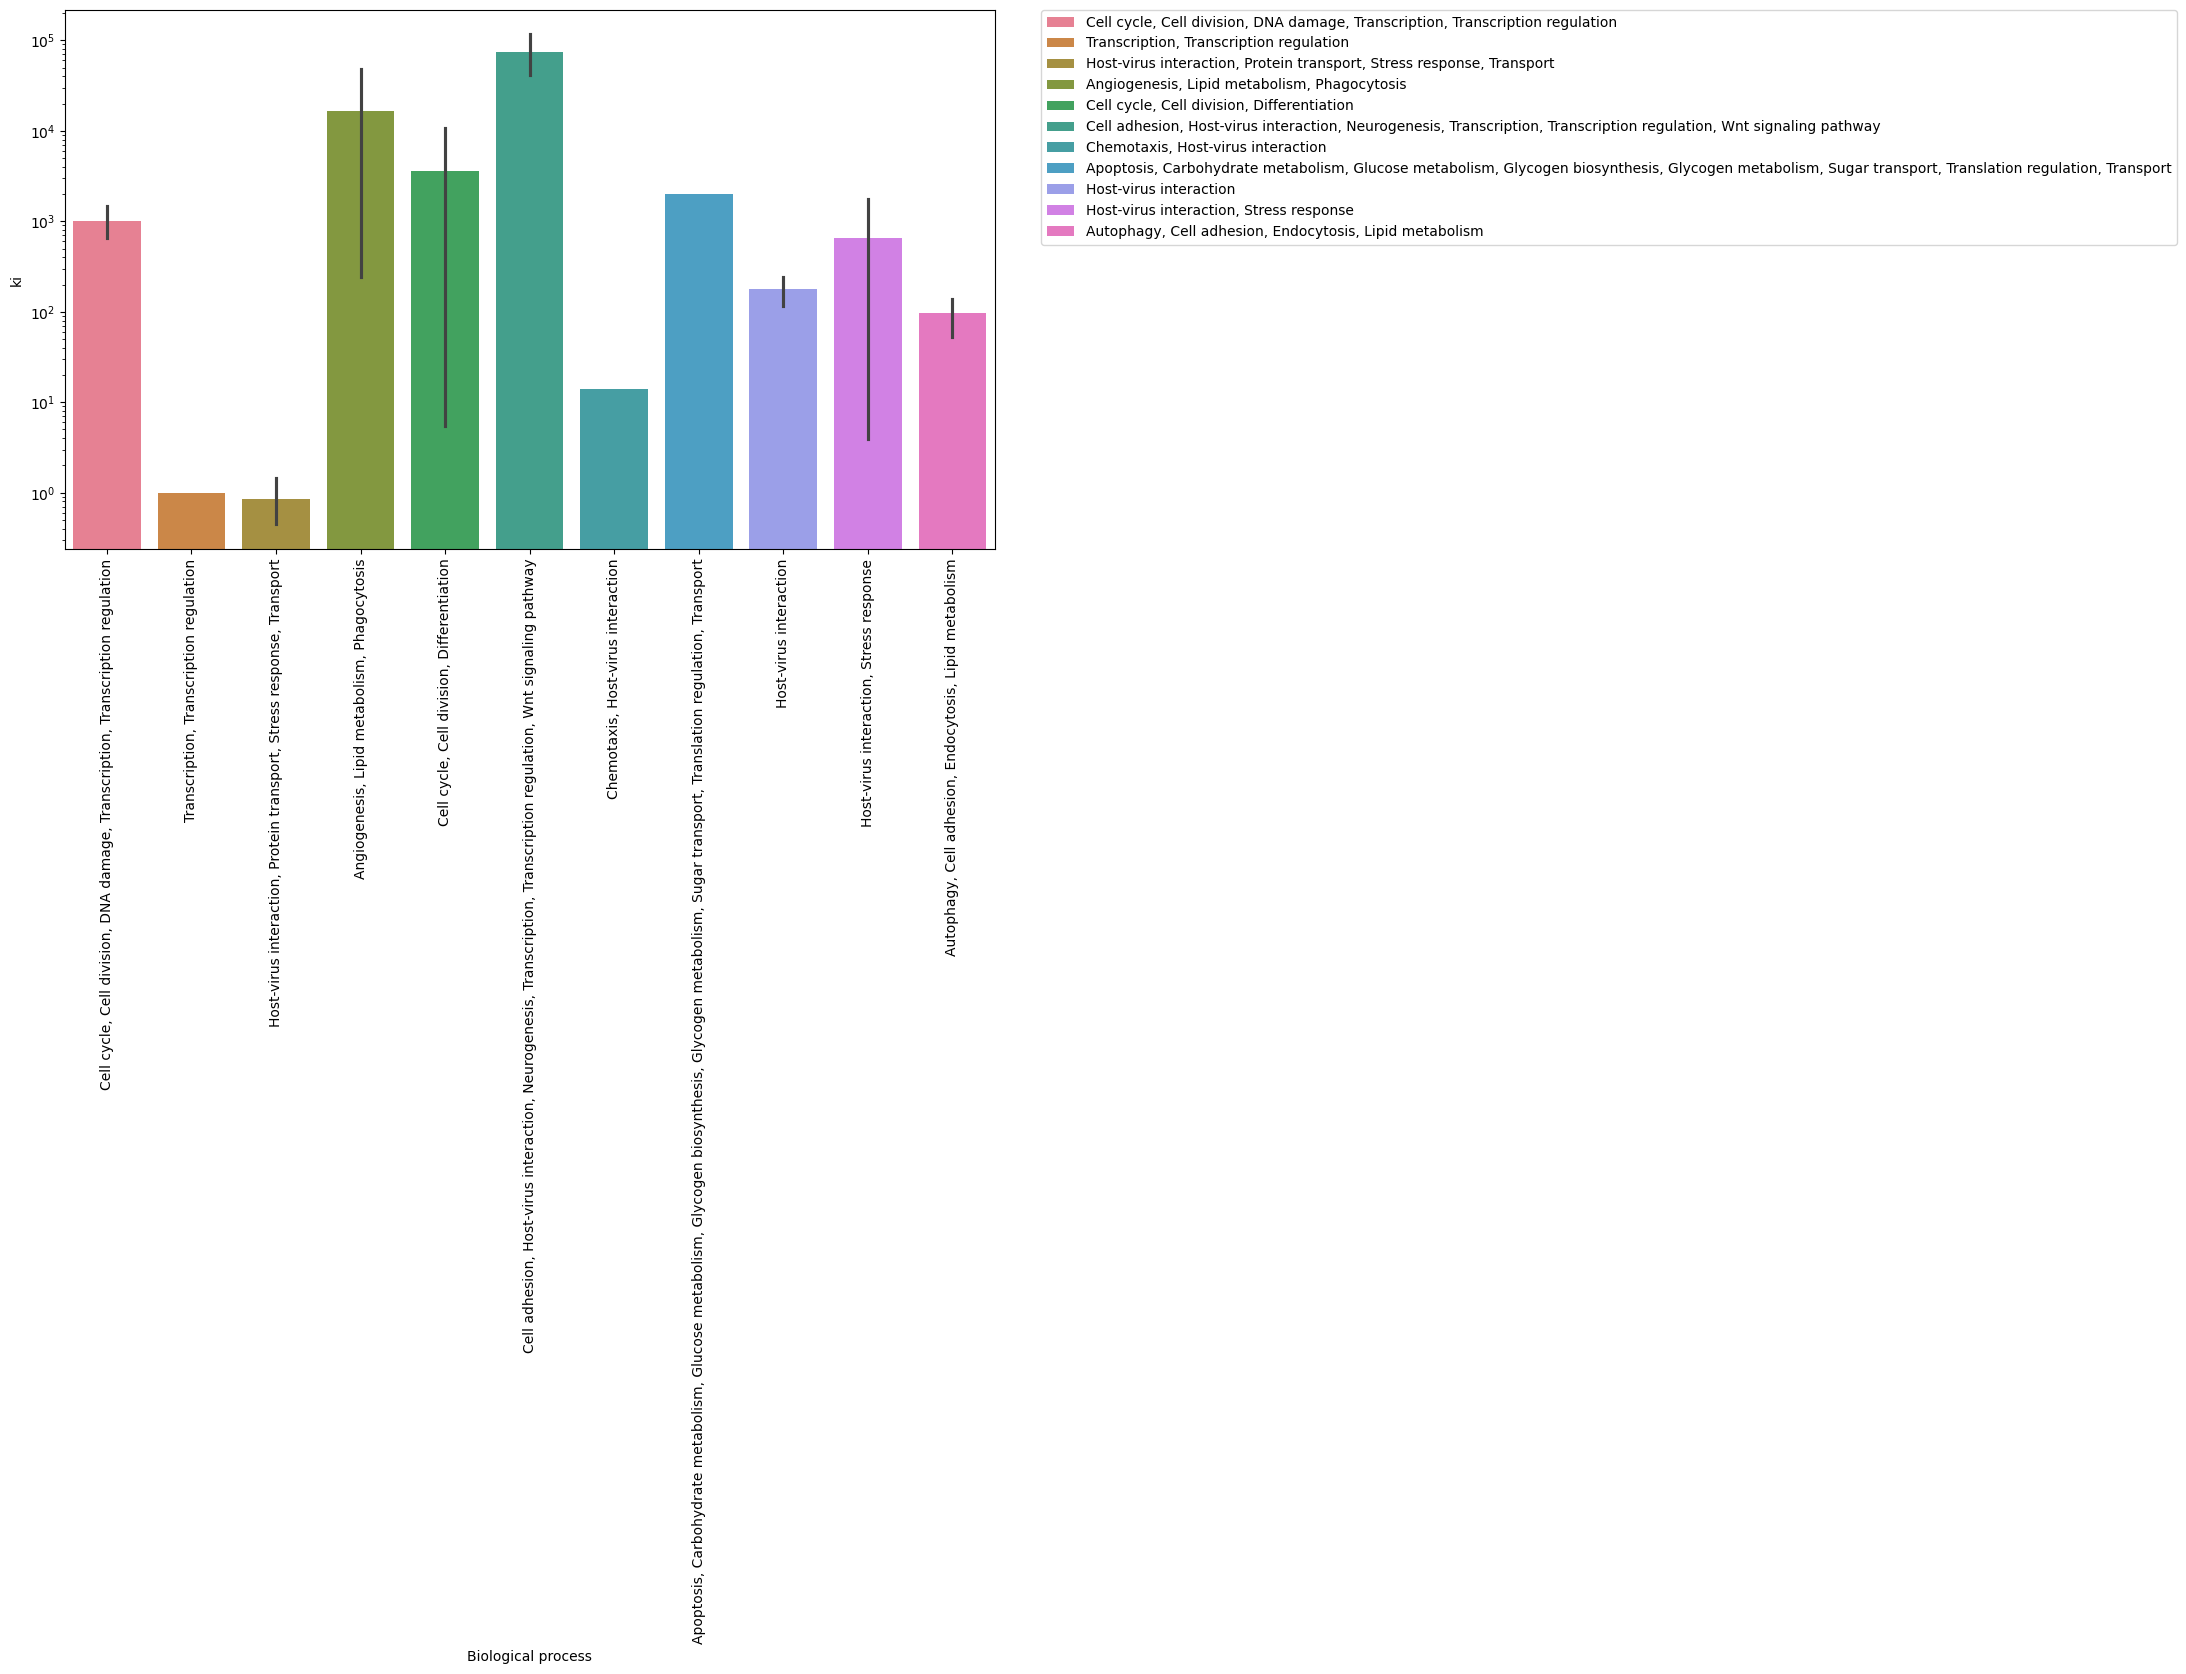

In [397]:
plt.figure(figsize=(12,7))
sns.barplot(x="Biological process", y="ki", hue="Biological process", data=df_ki)
plt.xticks(rotation=90)
plt.yscale("log")
# Adjust legend position (outside the plot)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)